In [ ]:
# default_exp plots

In [ ]:
#export
# Author: Simon Grah <simon.grah@thalesgroup.com>
#         Vincent Thouvenot <vincent.thouvenot@thalesgroup.com>

# MIT License

# Copyright (c) 2020 Thales Six GTS France

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

In [ ]:
#export
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_style("whitegrid")

# Plots

> Plot function for displaying Shapley Values

In [ ]:
#export
def plot_shapley(x, fc, ref, shapley_values, n_attributes):

    # Get output for x and ref
    pred_x = fc(x.values)
    # Individual reference or dataset of references
    if isinstance(ref, pd.core.series.Series):
        pred_ref = fc(ref.values)
    elif isinstance(ref, pd.core.frame.DataFrame):
        if ref.shape[0] == 1:
            ref = ref.iloc[0]
            pred_ref = fc(ref.values)
        else:
            rewards = []
            for idx in range(len(ref)):
                rewards.append(fc(ref.values[idx,:]))
            pred_ref = np.mean(rewards)

    # Create a series for plotting
    x_attributes = [feature + " = " + str(val) if isinstance(val, str) else feature + " = " + str(round(val,2)) for feature, val in x.iteritems()]
    s_plot = pd.Series(data=shapley_values.values, index=x_attributes)
    attributes = s_plot.abs().sort_values(ascending=False)[:n_attributes].index
    s_plot = s_plot[attributes]

    # Plot
    fig = plt.figure(figsize=(12,7))
    plt.ylim(ymin=0, ymax=len(attributes) + 1)

    # Cumulative horizontal arrows for Shapley values ordered by absolute values
    attribute_order = s_plot.abs().sort_values(ascending=False).index
    s_plot_sorted = s_plot[attribute_order]
    epsilon = 1e-5 # avoid arrows with width=0.
    past_val = 0.
    for idx, (attr, val) in enumerate(s_plot_sorted.iteritems()):
        if val >= 0:
            arrow = mpatches.FancyArrow(x=past_val, y=idx+1, dx=val+epsilon, dy=0, width=0.8, length_includes_head=True, head_width=0.8,
                                head_length=(val+epsilon)/10, shape='full', overhang=0, head_starts_at_zero=False, color="cornflowerblue")
            fig.get_axes()[0].add_patch(arrow)
            plt.text(x=past_val + val/2, y=idx+1, s="+"+str(round(val,2)), fontsize=20)
        else:
            arrow = mpatches.FancyArrow(x=past_val, y=idx+1, dx=val-epsilon, dy=0, width=0.8, length_includes_head=True, head_width=0.8,
                                head_length=-(val-epsilon)/10, shape='full', overhang=0, head_starts_at_zero=False, color="lightsalmon")
            fig.get_axes()[0].add_patch(arrow)
            plt.text(x=past_val + val/2, y=idx+1, s="-"+str(round(np.abs(val),2)), fontsize=20)
        if idx > 0:
            plt.vlines(past_val, ymin=idx, ymax=idx+1, colors="k", linewidth=1, linestyles="--")
        past_val += val

    # Rearrange yticks and its labels
    fig.get_axes()[0].set_yticks(range(1, len(attributes)+1))
    fig.get_axes()[0].set_yticklabels(list(s_plot_sorted.index))

    # Display vertical arrows for reference and x outputs
    width_ = np.abs(pred_x - pred_ref) / 100
    arrow = mpatches.FancyArrow(0, 0, 0, 1, width=width_, length_includes_head=True, head_width=width_,
                                head_length=0.2, shape='full', overhang=0, head_starts_at_zero=False,
                                color="forestgreen", label="reference output = "+str(round(pred_ref,2)))
    fig.get_axes()[0].add_patch(arrow)
    arrow = mpatches.FancyArrow(pred_x - pred_ref, idx+1, 0, 1, width=width_, length_includes_head=True, head_width=width_,
                                head_length=0.2, shape='full', overhang=0, head_starts_at_zero=False,
                                color="midnightblue", label="x output = "+str(round(pred_x,2)))
    fig.get_axes()[0].add_patch(arrow)

    # Rename xticks labels because zero is the reference reward
    xticks_label = np.round(fig.get_axes()[0].get_xticks() + pred_ref, 2)
    fig.get_axes()[0].set_xticklabels(xticks_label)

    plt.legend(loc='best')
    plt.xlabel("Output")
    plt.ylabel("x attributes")
    plt.show()

## Example

In [ ]:
#hide
d, n_samples = 5, 100
mu = np.zeros(d)
Sigma = np.zeros((d,d))
np.fill_diagonal(Sigma, [1] * d)
X = np.random.multivariate_normal(mean=mu, cov=Sigma, size=n_samples)
X = pd.DataFrame(X, columns=['x'+str(i) for i in range(1, d+1)])
def fc(x):
    phi_x = np.sqrt(.5 * np.pi) * np.exp(-0.5 * x ** 2)
    return np.prod(phi_x)
y = np.zeros(len(X))
for i in range(len(X)):
    y[i] = fc(X.values[i])
n = 2**d - 2
print("dimension = {0} ; nb of coalitions = {1}".format(str(d), str(n)))

dimension = 5 ; nb of coalitions = 30


In [ ]:
#hide
from shapkit.shapley_values import ShapleyValues

In [ ]:
#hide 
# Pick an individual x to explain
x = X.iloc[np.random.choice(len(X), size=1)[0],:]

# Single reference
reference = X.iloc[np.random.choice(len(X), size=1)[0],:]

# compute the exact Shapley Values 
true_shap = ShapleyValues(x=x, fc=fc, ref=reference)

100%|██████████| 5/5 [00:00<00:00, 254.58it/s]


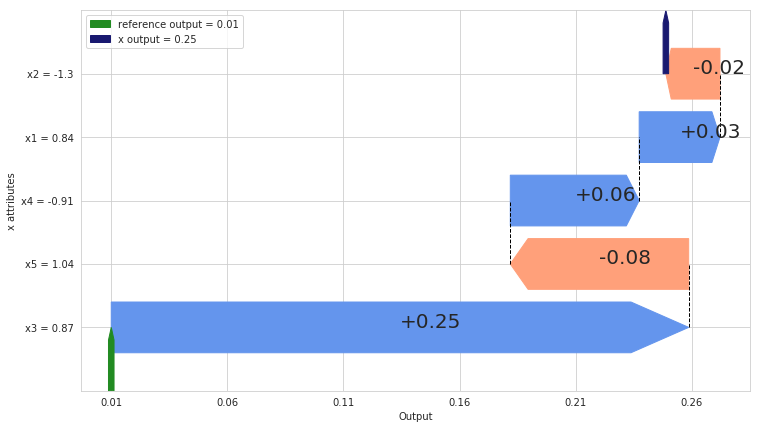

In [ ]:
plot_shapley(x=x, fc=fc, ref=reference, shapley_values=true_shap, n_attributes=5)

100%|██████████| 5/5 [00:00<00:00, 37.15it/s]


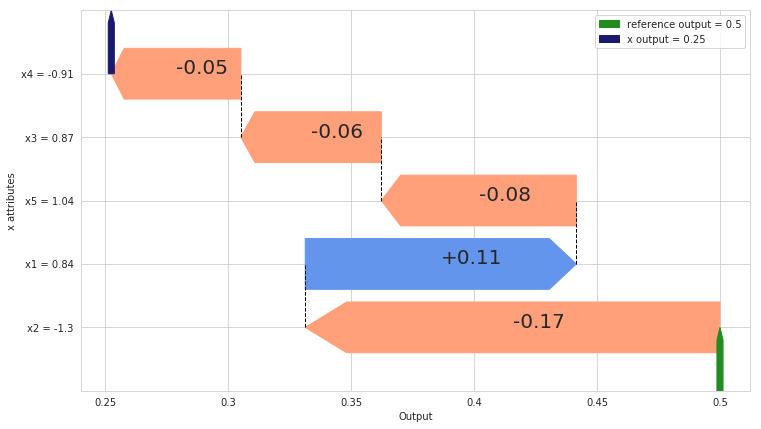

In [ ]:
# hide 
# Several references
references = X.iloc[np.random.choice(len(X), size=10, replace=False),:]

true_shaps = ShapleyValues(x=x, fc=fc, ref=references)

plot_shapley(x=x, fc=fc, ref=references, shapley_values=true_shaps, n_attributes=6)

## Export-

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted index.ipynb.
Converted inspector.ipynb.
Converted monte_carlo_shapley.ipynb.
Converted plots.ipynb.
Converted sgd_shapley.ipynb.
Converted shapley_values.ipynb.
